## Libraries and Imports

In [5]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil

# For reproducibility
np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping

import h5py

%matplotlib inline

## Parameters

In [6]:
training_dir = '../images/new_model'
test_dir     = '../test_images/'
image_height = 256
image_width  = 256
batch_size   = 64
num_epochs   = 50

## Model Construction

In [7]:
# Instantiates model
model = Sequential()

# First convolutional layer
model.add(Conv2D(8,
                 kernel_size=(3, 3),
                 strides=(1, 1),
                 padding='same',
                 activation='relu',       
                 input_shape=(image_height, image_width, 3))) 

     
# pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening layer
model.add(Flatten())

# Fully connected & dropout layers
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compiles model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

## Model Fitting

In [8]:
train_image_datagen = ImageDataGenerator(
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    rescale=1./255,
    #shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    #fill_mode='nearest',    # constant, nearest, reflect, wrap
    validation_split=0.2)

test_image_datagen = ImageDataGenerator(rescale=1./255)

training_generator = train_image_datagen.flow_from_directory(
    training_dir,
    target_size=(image_height, image_width), # Images resized to this.
    color_mode='rgb',
    batch_size = batch_size,
    class_mode='binary',
    subset='training')
    
validation_generator = train_image_datagen.flow_from_directory(
    training_dir,
    target_size=(image_height, image_width),
    batch_size = batch_size,
    class_mode='binary',
    subset='validation')

test_generator = test_image_datagen.flow_from_directory(
    test_dir,
    target_size = (image_height, image_width),
    shuffle=False,
    class_mode = 'binary',
    batch_size = 1)

# Stops model training early if overfitting is detected
es = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose = 1,
    restore_best_weights=True)

# Fits the model with 80/20 training/validation split
history = model.fit(
    training_generator,
    steps_per_epoch = training_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs=num_epochs,
    callbacks=[es]
)

Found 2983 images belonging to 2 classes.
Found 745 images belonging to 2 classes.
Found 11 images belonging to 1 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 46 steps, validate for 11 steps
Epoch 1/50
46/46 [==============================] - 107s 2s/step - loss: 0.9331 - accuracy: 0.5546 - val_loss: 0.6616 - val_accuracy: 0.6236
Epoch 2/50
46/46 [==============================] - 70s 2s/step - loss: 0.6290 - accuracy: 0.6304 - val_loss: 0.6188 - val_accuracy: 0.6577
Epoch 3/50
46/46 [==============================] - 69s 2s/step - loss: 0.6208 - accuracy: 0.6471 - val_loss: 0.6214 - val_accuracy: 0.7074
Epoch 4/50
46/46 [==============================] - 65s 1s/step - loss: 0.6093 - accuracy: 0.6591 - val_loss: 0.5931 - val_accuracy: 0.7017
Epoch 5/50
46/46 [==============================] - 69s 2s/step - loss: 0.5986 - accuracy: 0.6766 - val_loss: 0.5788 - val_accuracy: 0.6932
Epoch 6/50
46/46 [==============================] - 72s 2s/step - loss: 0.5997 - acc

## Summary & Analysis

In [9]:
training_generator.class_indices

{'0_people': 0, '1_landscapes': 1}

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2097168   
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 2,097,409
Trainable params: 2,097,409
Non-trainable params: 0
____________________________________________

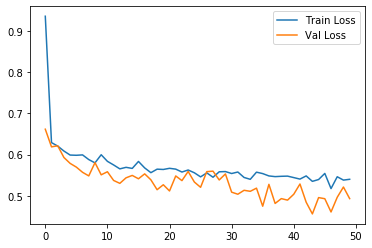

In [11]:
# Generates line plot for loss.
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend();

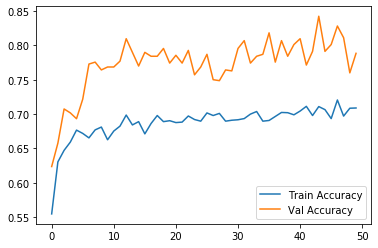

In [12]:
# Generates line plot for accuracy.
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend();

## Evaluate

In [13]:
# Evaluate model on test data.
score = model.evaluate(validation_generator,
                       verbose=1)

labels = model.metrics_names

# Show model performance.
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

  ...
    to  
  ['...']
12/12 [==============================] - 15s 1s/step - loss: 0.4968 - accuracy: 0.7839
loss: 0.4968318392833074
accuracy: 0.7838926315307617


## Save Model

In [20]:
model.save('../finished_model.h5')